In [1]:
using PyPlot
using FileIO
using Statistics
using LinearAlgebra

include("Common.jl")

Main.Common

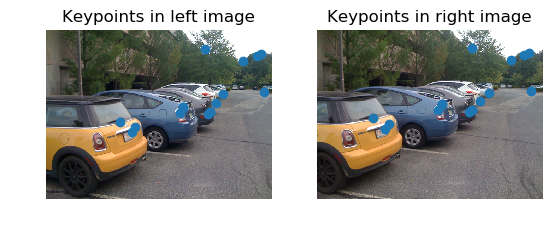

PyObject Text(0.5, 1.0, 'Keypoints in right image')

In [2]:
# Load images and points
img1 = Float64.(PyPlot.imread("a4p1a.png"))
img2 = Float64.(PyPlot.imread("a4p1b.png"))
points1 = load("points.jld2", "points1")
points2 = load("points.jld2", "points2")

# Display images and correspondences
figure()
subplot(121)
imshow(img1,interpolation="none")
axis("off")
scatter(points1[:,1],points1[:,2])
title("Keypoints in left image")
subplot(122)
imshow(img2,interpolation="none")
axis("off")
scatter(points2[:,1],points2[:,2])
title("Keypoints in right image")


In [3]:
#---------------------------------------------------------
# Conditioning: Normalization of coordinates for numeric stability.
#
# INPUTS:
#   points    unnormalized coordinates
#
# OUTPUTS:
#   U         normalized (conditioned) coordinates
#   T         [3x3] transformation matrix that is used for
#                   conditioning
#
#---------------------------------------------------------
function condition(points::Array{Float64,2})
  # just insert your assignment3 condition method here..
  P = points[1:2,:] ./ points[3:3,:]
  t = mean(P,dims=2)
  s = 0.5 * maximum(abs.(P))
  T = [[Matrix{Float64}(I, 2, 2) -t]./s; 0 0 1];
  U = T*points
  @assert size(U) == size(points)
  @assert size(T) == (3,3)
  return U::Array{Float64,2},T::Array{Float64,2}
end


#---------------------------------------------------------
# Enforce a rank of 2 to a given 3x3 matrix.
#
# INPUTS:
#   A     [3x3] matrix (of rank 3)
#
# OUTPUTS:
#   Ahat  [3x3] matrix of rank 2
#
#---------------------------------------------------------
# Enforce that the given matrix has rank 2
function enforcerank2(A::Array{Float64,2})
  U,D,V = svd(A)
  D[3] = 0
  Ahat = U*Diagonal(D)*V'
  @assert size(Ahat) == (3,3)
  return Ahat::Array{Float64,2}
end


#---------------------------------------------------------
# Compute fundamental matrix from conditioned coordinates.
#
# INPUTS:
#   p1     set of conditioned coordinates in left image
#   p2     set of conditioned coordinates in right image
#
# OUTPUTS:
#   F      estimated [3x3] fundamental matrix
#
#---------------------------------------------------------
# Compute the fundamental matrix for given conditioned points
function computefundamental(p1::Array{Float64,2},p2::Array{Float64,2})
  x = p1[1:1,:]'
  y = p1[2:2,:]'
  x2 = p2[1:1,:]'
  y2 = p2[2:2,:]'
  I = ones(length(x),1)
  A = [x.*x2 y.*x2 x2 x.*y2 y.*y2 y2 x y I]
  _,_,V = svd(A,full=true)
  Ft = permutedims(reshape(V[:,end],(3,3)), [2,1])
  F = enforcerank2(Ft)
  @assert size(F) == (3,3)
  return F::Array{Float64,2}
end


#---------------------------------------------------------
# Compute fundamental matrix from unconditioned coordinates.
#
# INPUTS:
#   p1     set of unconditioned coordinates in left image
#   p2     set of unconditioned coordinates in right image
#
# OUTPUTS:
#   F      estimated [3x3] fundamental matrix
#
#---------------------------------------------------------
function eightpoint(p1::Array{Float64,2},p2::Array{Float64,2})
  U1,T1 = condition(p1)
  U2,T2 = condition(p2)
  Ft = computefundamental(U1,U2)
  F = T2'*Ft*T1
  @assert size(F) == (3,3)
  return F::Array{Float64,2}
end

# compute fundamental matrix with homogeneous coordinates
x1 = Common.cart2hom(points1')
x2 = Common.cart2hom(points2')
F = eightpoint(x1,x2)

3×3 Array{Float64,2}:
 -1.16772e-8   -9.68289e-7   0.000376863
  9.88351e-7   -2.76568e-8  -0.00271324 
 -0.000340398   0.00268911  -0.0194118  

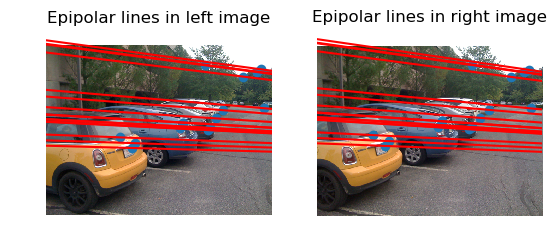

PyObject Text(0.5, 1.0, 'Epipolar lines in right image')

In [4]:
#---------------------------------------------------------
# Draw epipolar lines:
#   E.g. for a given fundamental matrix and points in first image,
#   draw corresponding epipolar lines in second image.
#
#
# INPUTS:
#   Either:
#     F         [3x3] fundamental matrix
#     points    set of coordinates in left image
#     img       right image to be drawn on
#
#   Or:
#     F         [3x3] transposed fundamental matrix
#     points    set of coordinates in right image
#     img       left image to be drawn on
#
#---------------------------------------------------------
function showepipolar(F::Array{Float64,2},points::Array{Float64,2},img::Array{Float64,3})
  # convert to homogenous
  npoints = size(points,1)
  P = Common.cart2hom(points')
  # line coefficients: x^T * l = 0,  with l = F*points = (a b c)^T
  l = F*P
  a = l[1:1,:]
  b = l[2:2,:]
  c = l[3:3,:]
  # first point of line
  X1 = zeros(1,npoints)
  Y1 = -(c + a.*X1)./b
  # second point of line
  X2 = X1 .+ size(img,2) .-1
  Y2 = -(c + a.*X2)./b
  # show lines on top of the given image
  imshow(img,interpolation="none")
  axis("off")
  for i = 1:npoints
    plot([X1[i],X2[i]], [Y1[i],Y2[i]],"r")
  end
  return nothing::Nothing
end

# draw epipolar lines
figure()
subplot(121)
F_transposed = permutedims(F, [2, 1])
showepipolar(F_transposed,points2,img1)
scatter(points1[:,1],points1[:,2])
title("Epipolar lines in left image")
subplot(122)
showepipolar(F,points1,img2)
scatter(points2[:,1],points2[:,2])
title("Epipolar lines in right image")

In [5]:
#---------------------------------------------------------
# Compute the residual errors for a given fundamental matrix F,
# and set of corresponding points.
#
# INPUTS:
#    p1    corresponding points in left image
#    p2    corresponding points in right image
#    F     [3x3] fundamental matrix
#
# OUTPUTS:
#   residuals      residual errors for given fundamental matrix
#
#---------------------------------------------------------
function computeresidual(p1::Array{Float64,2},p2::Array{Float64,2},F::Array{Float64,2})
  residual = sum(p2.*(F*p1),dims=1)
  residual = permutedims(residual, [2, 1]) # this step is not necessary
  return residual::Array{Float64,2}
end

# check epipolar constraint by computing the remaining residuals
residual = computeresidual(x1, x2, F)
println("Residuals:")
println(residual)
println("Sum(Residuals):")
println(sum(residual))
println("Max(Residuals):")
println(maximum(residual))

Residuals:
[-0.000151298; -0.000292893; -0.000532928; -0.000151298; -0.000348193; -0.00011442; -4.06446e-5; -5.09586e-5; 3.42938e-6; 0.000201883; -5.09586e-5; 0.000414918; -0.000383726; 2.06898e-5; 1.20415e-5; -1.71878e-5]
Sum(Residuals):
-0.001481542795284313
Max(Residuals):
0.00041491813451211


In [6]:
# compute epipoles
  U,_,V = svd(F)
  e1 = V[1:2,3]./V[3,3]
  println("Epipole 1: $(e1)")
  e2 = U[1:2,3]./U[3,3]
  println("Epipole 2: $(e2)")

Epipole 1: [2755.18, 355.979]
Epipole 2: [2766.41, 377.095]


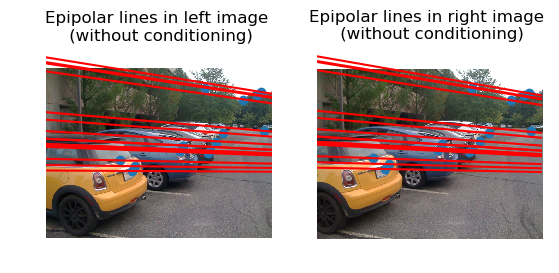

F:
[-1.16772e-8 -9.68289e-7 0.000376863; 9.88351e-7 -2.76568e-8 -0.00271324; -0.000340398 0.00268911 -0.0194118]
F without conditioning:
[-8.16247e-7 -5.62894e-5 0.0185028; 5.68822e-5 -3.24776e-6 -0.116432; -0.0163093 0.115965 -0.986097]
Sum(Residuals):
-0.001481542795284313
Sum(Residuals without conditioning):
0.862412954232732


PyObject Text(0.5, 1.0, 'Epipolar lines in right image \n (without conditioning)')

In [7]:
function eightpoint_wo_conditioning(p1::Array{Float64,2},p2::Array{Float64,2})
  F = computefundamental(p1,p2)
  @assert size(F) == (3,3)
  return F::Array{Float64,2}
end

# Computing the fundamental matrix without conditioning the points results in a different fundamental matrix 
# with a larger resdiual. This fact is due to numerical instabilities caused by the large numbers in matrix A. 
x1 = Common.cart2hom(points1')
x2 = Common.cart2hom(points2')
F_wo_conditioning = eightpoint_wo_conditioning(x1,x2)

println("F:")
println(F)
println("F without conditioning:")
println(F_wo_conditioning)

println("Sum(Residuals):")
println(sum(residual))
println("Sum(Residuals without conditioning):")
println(sum(computeresidual(x1, x2, F_wo_conditioning)))

# draw epipolar lines
figure()
subplot(121)
F_transposed_wo_conditioning = permutedims(F_wo_conditioning, [2, 1])
showepipolar(F_transposed_wo_conditioning,points2,img1)
scatter(points1[:,1],points1[:,2])
title("Epipolar lines in left image \n (without conditioning)")
subplot(122)
showepipolar(F_wo_conditioning,points1,img2)
scatter(points2[:,1],points2[:,2])
title("Epipolar lines in right image \n (without conditioning)")